### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle



### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

### Total columns

In [3]:
def grades(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked, booked = 5

def target_function(data_frame):
    #lklhd = hotel_booking_likelihood(data_frame)
    #data_frame_out = data_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    #x = data_frame['lklhd'].values #0.26-0.28
    #x = grades(data_frame) + data_frame['lklhd'].values #same as grading 1 click 5 book
    #x = grades(data_frame) 
    x = data_frame['grades'] 
    
    #x = (data_frame['click_bool'] + data_frame['booking_bool']*4)*np.log2(data_frame['position'] + 2) + data_frame['lklhd'].values
    #x = (data_frame['click_bool'] + 4*data_frame['booking_bool'])*(data_frame['position'] + 1)*(1+data_frame['lklhd'].values)#*(data_frame['gross_bookings_usd']+1) 

    return x
def features_engeneering(data_frame):
    #data_frame['month'] = pd.DatetimeIndex(pd.to_datetime(data_frame['date_time'])).month
    data_frame = data_frame.sort_values(by=['srch_id', 'price_usd'], ascending=[True,  False]).reset_index(drop=True)
    data_frame['price_order'] = data_frame.groupby('srch_id').cumcount()

    for i in ['orig_destination_distance']:
        data_frame[i] = data_frame[i].fillna(100)#(data_frame[i].max())
    
    for i in ['prop_review_score', 'prop_location_score2']:#, 'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']:
        data_frame[i] = data_frame[i].fillna(-1)
    
     
    data_frame = is_cheaper(data_frame)
    
    min_affinity = data_frame['srch_query_affinity_score'].min()
    #data_frame['srch_query_affinity_score'] = data_frame['srch_query_affinity_score'].fillna(min_affinity)
    
    
    average_user_usd = data_frame['visitor_hist_adr_usd'].mean()
    average_user_starrating = data_frame['visitor_hist_starrating'].mean()
    #data_frame['visitor_hist_adr_usd'] = \
    #data_frame['visitor_hist_adr_usd'].fillna(average_user_usd)
    #data_frame['visitor_hist_starrating'] = \
    #data_frame['visitor_hist_starrating'].fillna(average_user_starrating)
    
    data_frame['delta_starrating'] = np.abs(data_frame['visitor_hist_starrating'] - data_frame['prop_starrating'])
    data_frame['delta_usd'] = np.abs(data_frame['visitor_hist_adr_usd'] - data_frame['price_usd'])
    data_frame['delta_starrating'] = data_frame['delta_starrating'].fillna(0)
    data_frame['delta_usd'] = data_frame['delta_usd'].fillna(0)
    
    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    
    price_per_query_max = data_frame.groupby('srch_id').max().reset_index()
    price_per_query_max = price_per_query_max[['srch_id','price_usd']]
    price_per_query_max = price_per_query_max.rename(columns={"price_usd": "price_per_query_max"})

    #data_frame = data_frame.merge(price_per_country_median, how='left', left_on='prop_country_id', right_on='prop_country_id')
    #data_frame = data_frame.merge(price_per_query_max, how='left', left_on='srch_id', right_on='srch_id')
    
    # apply maximum price for missing values
    #mask = data_frame['price_usd'] == 0
    #data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_query_max']
    
    mask_log_0 = data_frame['prop_log_historical_price']==0 #no data assume same price
 
    data_frame['delta_log_price'] = np.log(data_frame['price_usd']) - data_frame['prop_log_historical_price']
    data_frame.loc[mask_log_0, 'delta_log_price'] = 0
     
    # normalization
    #data_frame['price_usd_normalized'] = data_frame['price_usd']/data_frame['price_per_country_median']
    
    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    #data_frame['price_per_person'] = data_frame['price_usd']/number_of_person
    
    return data_frame

def is_cheaper(df):
    #+1 if Expedia has a lower price than competitor ; 0 if the same; -1 if Expedia’s
    #price is higher than competitor 1; null signifies there is no competitive data
    
    # Drop all other comp columns, except for "rate"
    df = df.drop(df.filter(regex='(comp._inv|comp._rate.+)').columns, axis=1)
    # Create new col
    df['comp_cheaper'] = np.nan
    df_filter_comp = df.filter(regex='comp') 
    df['comp_cheaper'] = df['comp_cheaper'].mask((df_filter_comp == 0).any(axis=1),0).mask((df_filter_comp > 0).any(axis=1), 1).mask((df_filter_comp<0).any(axis=1), -1)
    # Drop old comp cols
    df = df.drop(df.filter(regex='comp._rate').columns, axis=1)
    df['comp_cheaper'] = df['comp_cheaper'].fillna(0)
    return df


In [4]:
train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')

mask = (train['random_bool']==True)
random_amount = len(train[mask])
print(f'random amount: {random_amount}')

mask = (train['random_bool']==False)
non_random_amount = len(train[mask])
print(f'non-random amount: {non_random_amount}')
print(f'random are: {random_amount/(random_amount+non_random_amount)*100}')




train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604
random amount: 1467177
non-random amount: 3491170
random are: 29.590042810638305


### Total null columns

In [17]:
train['relevance'] = grades(train)
#train_eng = features_engeneering(train)

train.drop(train.filter(regex='(comp)').columns, axis=1, inplace=True)
FF = train.filter(regex='^(?!.*(srch_id|click_bool|position|booking_bool|gross_bookings_usd)).*')


corr_matrix = FF.corr()


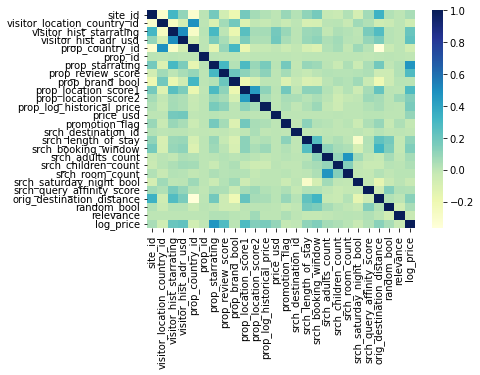

In [19]:
dataplot=sns.heatmap(corr_matrix, xticklabels=True, yticklabels=True, cmap="YlGnBu")

,srch_id,prop_id,booking_bool,click_bool,grades
0,1,1,1,1,5
1,1,2,0,0,0
2,1,4,0,1,1
3,2,1,1,1,5
4,2,2,0,0,0
5,2,3,0,0,0
6,3,1,0,0,0
7,3,2,0,0,0
8,3,3,1,1,5
9,4,1,0,1,1


prop_id
1    0.5
2    0.0
3    3.0
Name: grades, dtype: float64


0   NaN
1   NaN
2   NaN
3   NaN
Name: kfold, dtype: float64

,srch_id,prop_id,booking_bool,click_bool,grades,kfold
0,1,1,1,1,5,1.0
1,1,2,0,0,0,1.0
2,1,4,0,1,1,1.0
3,2,1,1,1,5,1.0
4,2,2,0,0,0,1.0
5,2,3,0,0,0,1.0
6,3,1,0,0,0,1.0
7,3,2,0,0,0,1.0
8,3,3,1,1,5,1.0
9,4,1,0,1,1,1.0


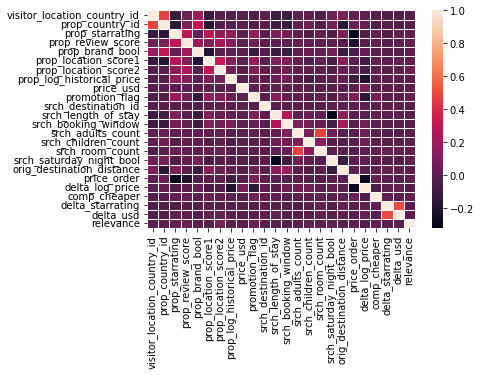

In [7]:
FF = train_eng.filter(regex='^(?!.*(srch_query|srch_id|click_bool|position|booking_bool|gross_bookings_usd)).*')
features = ['visitor_location_country_id',
 'prop_country_id',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'prop_log_historical_price',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'orig_destination_distance',
 'price_order',
 #'kfold_lklhd',
 'delta_log_price',
 'comp_cheaper',
 'delta_starrating',
 'delta_usd','relevance']

dataplot=sns.heatmap(train_eng[features].corr(), xticklabels=True, yticklabels=True, linewidths=.6)

In [8]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

### Amount of hotels in data sets

In [9]:
x = test['prop_id']
print(f'Amount of hotels in test data {len(set(x))} ')
y = train['prop_id']
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels in train and not in test {len(set(x) - set(y))}')


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels in train and not in test 7773


### price distribution

Text(10.049999999999997, 0.5, 'count')

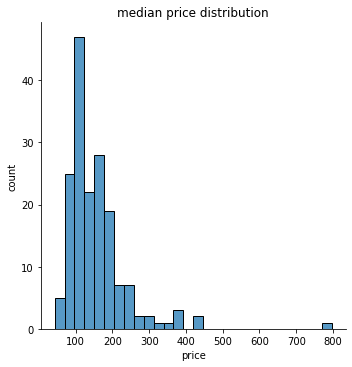

In [10]:
price_per_country_median = train.groupby('prop_country_id').median().reset_index()
price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
ax = sns.displot(data = price_per_country_median, x='price_per_country_median')
plt.title('median price distribution')
plt.xlabel('price')
plt.ylabel('count')

Text(9.924999999999997, 0.5, 'count')

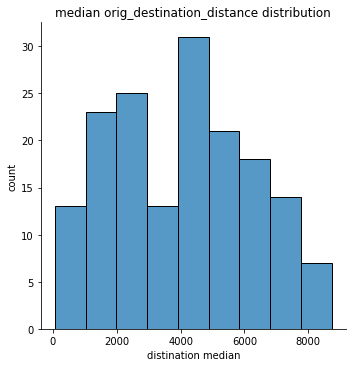

In [11]:
country_median = train.groupby('prop_country_id').median().reset_index()
country_median = country_median[['prop_country_id','orig_destination_distance']]

country_median = country_median.rename(columns={"orig_destination_distance": "orig_destination_median"})

ax = sns.displot(data = country_median, x='orig_destination_median')
plt.title('median orig_destination_distance distribution')
plt.xlabel('distination median')
plt.ylabel('count')

2871


,price_usd
11422,14196.00
11423,17812.00
11424,12447.00
11425,13392.00
11426,17410.00
...,...
4930760,5328.00
4930761,8610.00
4930764,5166.00
4930773,8556.00


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/frame.py:8823: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


0.0


Text(19.428124999999994, 0.5, 'count')

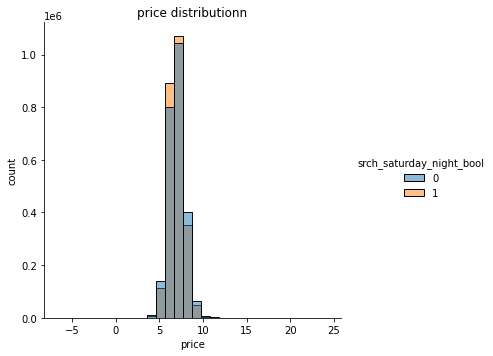

In [12]:
mask = (train['price_usd']>5000)# & (train['booking_bool']==True)
print(len(train.loc[mask]))
display(train.loc[mask, ['price_usd']])
train[['log_price']] = train[['price_usd']].applymap(np.log2)
print(train['price_usd'].min())

ax = sns.displot(data = train, hue="srch_saturday_night_bool", x='log_price', bins=30)

plt.title('price distributionn')
plt.xlabel('price')
plt.ylabel('count')

In [13]:
x = range(1,6,2)
for n in x:
  print(n)

1
3
5


In [14]:
train['price_usd'].median() + train['price_usd'].std()*5

80128.18530749762

<AxesSubplot:xlabel='date_time'>

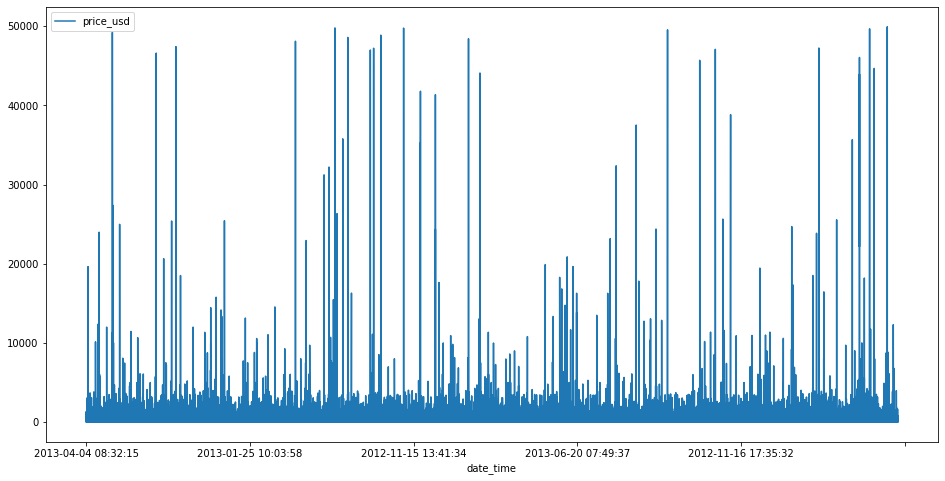

In [15]:
mask = train['price_usd']<50000
train[mask].plot(x = 'date_time', 
        y = 'price_usd', 
        figsize = (16, 8))

In [16]:
mask = train['booking_bool'] == True
train.loc[mask,['prop_location_score1', 'prop_location_score2']]
train.loc[mask,['prop_location_score1', 'prop_location_score2']].max()

prop_location_score1    6.97
prop_location_score2    1.00
dtype: float64